<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Functionality  Evals</h1>


This tests whether code is written correctly, without bugs, accomplishes the functionality you want, does not have syntax errors.

The purpose of this notebook is:

- to evaluate the performance of code fuctionality Eval
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [8]:
#!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [9]:
import nest_asyncio

nest_asyncio.apply()

In [10]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import pandas as pd
from phoenix.experimental.evals import (
    CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    CODE_FUNCTIONALITY_PROMPT_RAILS_MAP,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

TODO

In [11]:
df = pd.read_csv("https://storage.googleapis.com/arize-assets/phoenix/evals/code-functionality/validated_python_code_samples_2.csv")

df.head()

,coding_instruction,code,is_well_coded
0,Create a neural network in Python from scratch that takes a 2D array of numbers as its input and predicts the sum of the numbers in each row.,"import numpy as np\n\nclass NeuralNetwork:\n def __init__(self, input_size):\n self.weights = np.random.rand(input_size, 1)\n self.bias = np.random.rand(1, 1)\n\n def predict(self, X):\n return np.dot(X, self.weights) + self.bias\n\n# Example Usage:\ninput_data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])\nnn = NeuralNetwork(input_size=input_data.shape[1])\npredictions = nn.predict(input_data)\nprint(predictions)",True
1,Generate a Python program to find the mode of the given list.,"from statistics import mode\n\ndef find_mode(input_list):\n try:\n result = mode(input_list)\n return result\n except StatisticsError:\n return ""No unique mode found""\n\n# Example Usage:\ndata_list = [1, 2, 2, 3, 4, 4, 5]\nmode_result = find_mode(data_list)\nprint(mode_result)",True
2,Develop a text summarizer in Python that takes a text input and returns a summary of the text in two sentences.,"from nltk import sent_tokenize\nfrom nltk.corpus import stopwords\nfrom nltk.stem import PorterStemmer\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.metrics.pairwise import cosine_similarity\n\ndef text_summarizer(text):\n sentences = sent_tokenize(text)\n stop_words = set(stopwords.words('english'))\n vectorizer = TfidfVectorizer()\n ps = PorterStemmer()\n\n def preprocess_sentence(sentence):\n words = [ps.stem(word) for word in sentence.split() if word.lower() not in stop_words]\n return ' '.join(words)\n\n preprocessed_sentences = [preprocess_sentence(sentence) for sentence in sentences]\n\n try:\n tfidf_matrix = vectorizer.fit_transform(preprocessed_sentences)\n sentence_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)\n except ValueError:\n return ""Input text is too short for summarization.""\n\n sentence_scores = [(index, sum(sentence_similarity[index])) for index in range(len(sentences))]\n sentence_scores = sorted(sentence_scores, key=lambda x: x[1], reverse=True)\n\n summary_sentences = [sentences[score[0]] for score in sentence_scores[:2]]\n summary = ' '.join(summary_sentences)\n\n return summary\n\n# Example Usage:\ninput_text = ""Your input text goes here. It should be a longer piece of text for meaningful summarization.""\nsummary_result = text_summarizer(input_text)\nprint(summary_result)",True
3,Create a program in Python to generate random passwords of 8 characters.,import random\nimport string\n\ndef generate_random_password():\n password_length = 8\n characters = string.ascii_letters + string.digits + string.punctuation\n password = ''.join(random.choice(characters) for i in range(password_length))\n return password\n\n# Example Usage:\nrandom_password = generate_random_password()\nprint(random_password),True
4,Design a python program to replace every occurrence of a word in a string with another word.,"def replace_word(string, word, replacement_word):\n return string.replace(word)\n\nprint(replace_word(""Hello hello world!"", ""hello"", ""welcome""))",False




```
# This is formatted as code
```

## Display Code Functionality Classification Template

View the default template used to code functionality. You can tweak this template and evaluate its performance relative to the default.

In [12]:
print(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP)

OrderedDict([(True, 'bug_free'), (False, 'is_bug')])


In [13]:
print(CODE_FUNCTIONALITY_PROMPT_TEMPLATE)


Code Evaluation Prompt:
-----------------------
Evaluate the provided code to determine its correctness in solving the given instruction.

Data:
-----
[Instruction]: {coding_instruction}
  Clearly define the task or problem that the code aims to address.

[Reference Code]: {code}
  Examine the submitted code for evaluation in the context of the provided instruction.

Evaluation:
-----------
Provide a concise response with a single word: either "bug_free" or "is_bug".
- "bug_free" signifies that the code correctly and efficiently solves the instruction with no bugs.
- "is_bug" indicates that the code either fails to meet the instruction requirements or contains bugs.

Example:
-----------

[Instruction]: Implement the Fibonacci sequence in Python.

[Reference Code]: 'def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

for i in range(10):
    print(fibonacci(i))'

[Output]: bug_free

Note: Assumptions can be made that any code 

The template variables are:

- **coding_instruction:** Instructions of code to write
- **reference:** Code that was written (represents AI code for AI code generation): Note: these examples are hand created from a dataset
- **is_well_coded :** Does it functionaliy do what was desired, is it bug free, no syntax errors 

## Configure the LLM

Configure your OpenAI API key.

In [14]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

## LLM Evals: Code Functionality Classifications GPT-4
Run Code Functionality against a subset of the data.
Instantiate the LLM and set parameters.

In [15]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [16]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

## Run Code Func Classifications

Run code functionality classifications against a subset of the data.

In [17]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:11<00:00 |  4.41it/s


## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth code functionality labels.

              precision    recall  f1-score   support

    bug_free       0.96      0.77      0.86        31
      is_bug       0.72      0.95      0.82        19

    accuracy                           0.84        50
   macro avg       0.84      0.86      0.84        50
weighted avg       0.87      0.84      0.84        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

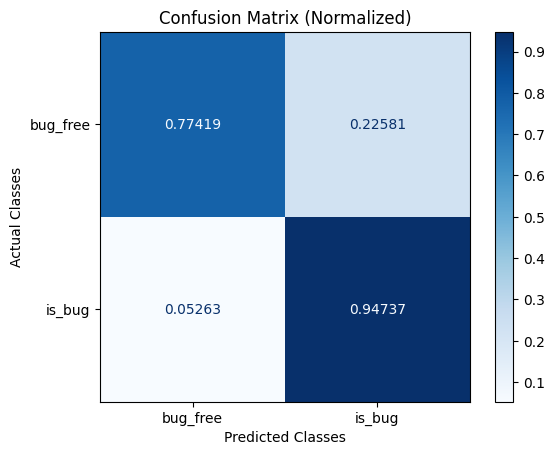

In [18]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for code functionality, it can be useful to know why the LLM classified a document as relevant or irrelevant. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [19]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
relevance_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


Code Evaluation Prompt:
-----------------------
Evaluate the provided code to determine its correctness in solving the given instruction.

Data:
-----
[Instruction]: {coding_instruction}
  Clearly define the task or problem that the code aims to address.

[Reference Code]: {code}
  Examine the submitted code for evaluation in the context of the provided instruction.

Evaluation:
-----------
Provide a concise response with a single word: either "bug_free" or "is_bug".
- "bug_free" signifies that the code correctly and efficiently solves the instruction with no bugs.
- "is_bug" indicates that the code either fails to meet the instruction requirements or contains bugs.

Example:
-----------

[Instruction]: Implement the Fibonacci sequence in Python.

[Reference Code]: 'def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

for i in range(10):
    print(fibonacci(i))'

[Output]: bug_free

Note: Assumptions can be made

llm_classify |██        | 1/5 (20.0%) | ⏳ 00:07<00:28 |  7.03s/it

- Snapped 'is_bug' to rail: is_bug


llm_classify |████      | 2/5 (40.0%) | ⏳ 00:12<00:17 |  5.86s/it 

- Snapped 'bug_free' to rail: bug_free


llm_classify |██████    | 3/5 (60.0%) | ⏳ 00:13<00:07 |  3.62s/it 

- Snapped 'is_bug' to rail: is_bug


llm_classify |████████  | 4/5 (80.0%) | ⏳ 00:18<00:04 |  4.25s/it 

- Snapped 'bug_free' to rail: bug_free


llm_classify |██████████| 5/5 (100.0%) | ⏳ 00:19<00:00 |  3.23s/it

- Snapped 'bug_free' to rail: bug_free


llm_classify |██████████| 5/5 (100.0%) | ⏳ 00:20<00:00 |  4.13s/it


In [20]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, relevance_classifications_df, left_index=True, right_index=True
)
merged_df[["coding_instruction", "code", "label", "explanation"]].head()

,coding_instruction,code,label,explanation
0,Generate a python program to normalize a list of values in the range 0 and 1,def normalize_list(input_list):\n min_val = min(input_list)\n max_val = max(input_list)\n output_list = []\n for value in input_list:\n normalized_value = (value - min_val) / (max_val - min_val)\n output_list.append(normalized_value)\n return output_list,bug_free,"The provided Python code is designed to normalize a list of values in the range 0 and 1. The function 'normalize_list' takes an input list, finds the minimum and maximum values in the list, and then iterates over the list to calculate the normalized value for each element. The normalized value is calculated by subtracting the minimum value from the current value and dividing the result by the difference between the maximum and minimum values. This operation scales all values in the list to a range between 0 and 1, which is the desired outcome. The function then returns the list of normalized values. The code does not contain any syntax errors, and it correctly implements the normalization formula. Therefore, it should work as expected for any list of numerical values, assuming that the list is not empty and does not contain non-numerical values."
1,Design a polynomial class in Python that stores the coefficients of an n-th degree polynomial function.,"class Polynomial: \n def __init__(self, coefficients): \n self.coefficients = coefficients\n\n def __call__(self, x):\n result = 0\n for i, c in enumerate(self.coefficients):\n result = c * x**i\n return result",is_bug,"The Polynomial class is designed to store the coefficients of an n-th degree polynomial function. However, the __call__ method, which is supposed to evaluate the polynomial at a given value of x, contains a bug. In the loop where it calculates the result, it should accumulate the result by adding to the previous result, not by assigning the new value to the result. In its current form, the method only returns the last term of the polynomial, not the sum of all terms."
2,Create a Python script that makes an HTTP request to retrieve data and convert it from JSON to a pandas DataFrame.,import requests\nimport pandas as pd\n\nurl = 'https://example.com/api/data'\n\n# Make the request and get the response\nresponse = requests.get(url)\n\n# Convert the JSON response to a python dictionary\ndata = response.json()\n\n# Convert the dictionary to a pandas DataFrame\ndf = pd.DataFrame(data),bug_free,"The provided Python script correctly makes an HTTP GET request to the specified URL using the requests library. It then converts the JSON response to a Python dictionary using the json() method of the response object. Finally, it converts the dictionary to a pandas DataFrame using the DataFrame() constructor of the pandas library. The code does not contain any syntax errors or logical bugs, and it correctly implements the task described in the instruction. However, it's important to note that the code does not handle potential exceptions that might occur during the execution, such as network errors, invalid JSON data, or issues with converting the data to a DataFrame. But since the instruction does not specify the need for error handling, we can consider this code as 'bug_free' in the context of the given instruction."
3,Generate a Python program to find the mode of the given list.,"from statistics import mode\n\ndef find_mode(input_list):\n try:\n result = mode(input_list)\n return result\n except StatisticsError:\n return ""No unique mode found""\n\n# Example Usage:\ndata_list = [1, 2, 2, 3, 4, 4, 5]\nmode_result = find_mode(data_list)\nprint(mode_result)",bug_free,"The provided Python code is intended to find the mode of a given list. The mode is the value that appears most frequently in a data set. The code uses the 'mode' function from the 'statistics' module in Python, which returns the single most common data point from the discrete or nominal data. If there is not exactly one most common val

## LLM Evals: code functionality Classifications GPT-3.5 Turbo
Run Code functionality against a subset of the data using GPT-3.5. GPT-3.5 can significantly speed up the classification process. However there are tradeoffs as  we will see below.

In [21]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [22]:
rails = list(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:11<00:00 |  4.43it/s


              precision    recall  f1-score   support

    bug_free       0.82      0.90      0.86        31
      is_bug       0.81      0.68      0.74        19

    accuracy                           0.82        50
   macro avg       0.82      0.79      0.80        50
weighted avg       0.82      0.82      0.82        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

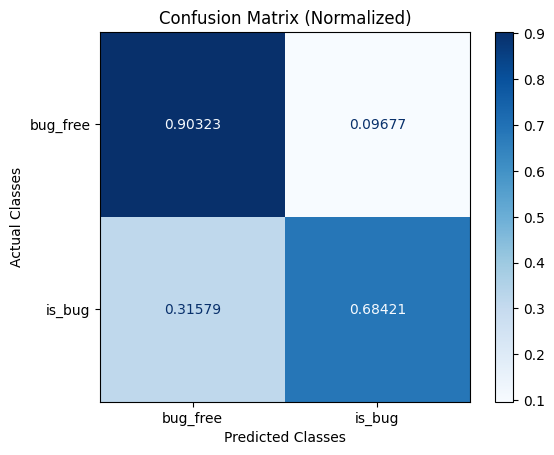

In [23]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Preview: Running with GPT-4 Turbo

In [24]:
model = OpenAIModel(model_name="gpt-4-1106-preview")
classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=list(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP.values()),
    concurrency=20,
)["label"].tolist()

llm_classify |██████████| 50/50 (100.0%) | ⏳ 00:11<00:00 |  4.49it/s


              precision    recall  f1-score   support

    bug_free       1.00      0.77      0.87        31
      is_bug       0.73      1.00      0.84        19

    accuracy                           0.86        50
   macro avg       0.87      0.89      0.86        50
weighted avg       0.90      0.86      0.86        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

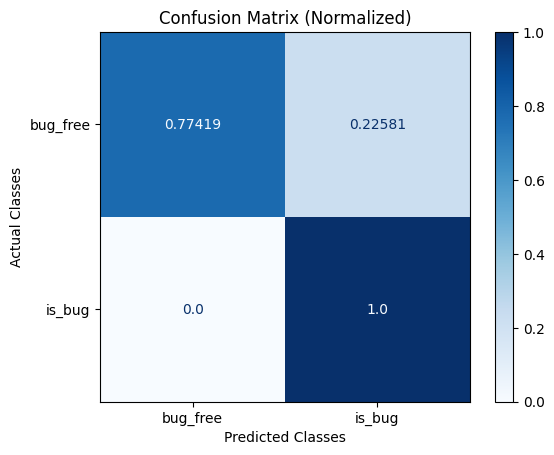

In [25]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)